In [1]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray as xr

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

In [2]:
model_name = 'v1/deterministic_1_4_deg.pkl'  #@param ['v1/deterministic_0_7_deg.pkl', 'v1/deterministic_1_4_deg.pkl', 'v1/deterministic_2_8_deg.pkl', 'v1/stochastic_1_4_deg.pkl', 'v1_precip/stochastic_precip_2_8_deg.pkl', 'v1_precip/stochastic_evap_2_8_deg'] {type: "string"}

gcs = gcsfs.GCSFileSystem(token='anon')
with gcs.open(f'gs://neuralgcm/models/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

In [3]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xr.open_zarr(
    era5_path, chunks=None, storage_options=dict(token='anon')
)

demo_start_time = '2018-01-01'
demo_end_time = '2018-01-02'
data_inner_steps = 24  # process every 24th hour

sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

In [4]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

In [8]:
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 1 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

# initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  # optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)
predictions_ds = model.data_to_xarray(predictions, times=eval_era5.isel(time=[0]).time+np.timedelta64(1, 'D'))

AttributeError: 'list' object has no attribute 'shape'

NameError: name 'corrected_inputs' is not defined

In [33]:
new_predictions_ds = model.data_to_xarray(predictions, times=predictions_ds.isel(time=[-1]).time+np.timedelta64(1, 'D'))
new_predictions_ds

<xarray.Dataset> Size: 34MB
Dimensions:                              (time: 1, level: 37, longitude: 256,
                                          latitude: 128)
Coordinates:
  * time                                 (time) datetime64[ns] 8B 2018-01-03
  * longitude                            (longitude) float64 2kB 0.0 ... 358.6
  * latitude                             (latitude) float64 1kB -88.93 ... 88.93
  * level                                (level) int64 296B 1 2 3 ... 975 1000
Data variables:
    geopotential                         (time, level, longitude, latitude) float32 5MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 5MB ...
    temperature                          (time, level, longitude, latitude) float32 5MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 5MB ...
    specific_humidity                    (time, level, longitude, latitude) float32 5MB ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 5MB ...
    sim_time                             (time) float32 4B ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 5MB ...
Attributes:
    longitude_wavenumbers:     128
    total_wavenumbers:         129
    longitude_nodes:           256
    latitude_nodes:            128
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonicsWithZeroImag
    spmd_mesh:                 
    centers:                   [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, ...
    horizontal_grid_type:      Grid
    vertical_grid_type:        PressureCoordinates

In [51]:
# initial_state_ds = eval_era5.isel(time=0)
# perturbation = (1/1000)*eval_era5.isel(time=0)
# [predictions_aligned, initial_state_aligned, perturbation_aligned] = xr.align(*[predictions_ds, initial_state_ds, perturbation], join='override')
# mean_state_correction = predictions_aligned - initial_state_aligned
# corrected_term = predictions_aligned - mean_state_correction
# corrected_term_with_perturbation = predictions_aligned - mean_state_correction + perturbation_aligned
corrected_input = model.inputs_from_xarray(corrected_term.isel(time=0))
# perturbed_input = model.inputs_from_xarray(corrected_term_with_perturbation)
# corrected_input.keys()
# corrected_term
# corrected_input['sim_time'] = corrected_input['sim_time'][0]
# corrected_input['sim_time']
# print(inputs['sim_time'])
new_initial_state = model.encode(corrected_input, input_forcings, rng_key)
new_initial_state

# for data_var in corrected_input.keys():
#     print(data_var, np.shape(corrected_input[data_var]), np.shape(inputs[data_var]))

ModelState(state=State(vorticity=Array([[[-5.2022347e-03, -4.3626916e-02,  1.1082252e-01, ...,
         -1.0080119e-09,  3.5551190e-10, -0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00, -1.0154492e-03, -8.3187660e-03, ...,
          1.5796816e-08, -2.9929901e-09,  0.0000000e+00],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.2851845e-09, -1.0358151e-09, -0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00, -1.5949722e-09, -0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00, -2.9368202e-10,  0.0000000e+00]],

       [[-4.3336302e-03,  8.8997213e-03,  5.8897175e-02, ...,
         -6.9199468e-09, -2.6664257e-10, -0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.000000

In [213]:
# print(test_outputs.latitude.values - regridded_data.latitude.values)
aligned_prediction, aligned_initial_condition = xr.align(predictions_ds, initial_state, join='override')
modified_data = aligned_output - aligned_data
model.inputs_from_xarray(modified_data)

{'geopotential': array([[[[ 1400.75    , -3025.2188  ,  -481.53125 , ...,   585.46875 ,
           -1810.25    ,   799.375   ],
          [ 1394.3125  , -3005.5625  ,  -544.25    , ...,   556.75    ,
           -1821.4375  ,   838.59375 ],
          [ 1394.2812  , -2978.6562  ,  -583.9375  , ...,   532.53125 ,
           -1827.2188  ,   879.96875 ],
          ...,
          [ 1408.2188  , -3092.2812  ,  -252.28125 , ...,   689.90625 ,
           -1756.75    ,   692.34375 ],
          [ 1403.2188  , -3067.3438  ,  -329.625   , ...,   652.1875  ,
           -1778.2812  ,   726.46875 ],
          [ 1399.8438  , -3047.2812  ,  -402.875   , ...,   617.59375 ,
           -1796.2812  ,   763.25    ]],
 
         [[ 1878.75    , -1220.3125  ,  1293.7812  , ...,  1453.6562  ,
            -743.4375  ,   834.09375 ],
          [ 1862.3125  , -1225.2812  ,  1349.5625  , ...,  1440.5938  ,
            -741.84375 ,   843.59375 ],
          [ 1839.5938  , -1229.3125  ,  1394.2812  , ...,  1432.4375  

In [207]:
test_outputs

<xarray.Dataset> Size: 34MB
Dimensions:                              (time: 1, level: 37, longitude: 256,
                                          latitude: 128)
Coordinates:
  * time                                 (time) datetime64[ns] 8B 2018-01-01
  * longitude                            (longitude) float64 2kB 0.0 ... 358.6
  * latitude                             (latitude) float64 1kB -88.93 ... 88.93
  * level                                (level) int64 296B 1 2 3 ... 975 1000
Data variables:
    specific_humidity                    (time, level, longitude, latitude) float32 5MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 5MB ...
    sim_time                             (time) float32 4B ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 5MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 5MB ...
    temperature                          (time, level, longitude, latitude) float32 5MB ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 5MB ...
    geopotential                         (time, level, longitude, latitude) float32 5MB ...
Attributes:
    longitude_wavenumbers:     128
    total_wavenumbers:         129
    longitude_nodes:           256
    latitude_nodes:            128
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonicsWithZeroImag
    spmd_mesh:                 
    centers:                   [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, ...
    horizontal_grid_type:      Grid
    vertical_grid_type:        PressureCoordinates

<xarray.DataArray 'specific_humidity' ()> Size: 8B
array(-0.00079587)

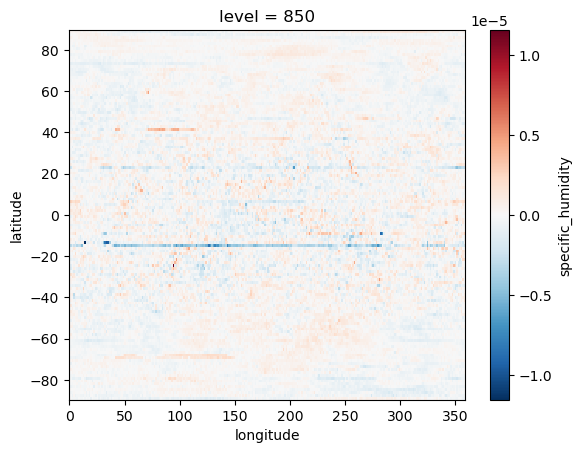

In [60]:
# new_data = xr.open_dataset('./multi_day_2018-01-01_deterministic_cf_corrected.nc')
# diff = (
#     new_data['specific_humidity'].isel(time=1)
#     - new_data['specific_humidity'].isel(time=0)
# )
diff.sel(level=850).plot(y='latitude')
new_data['specific_humidity'].max()
new_data['specific_humidity'].min()

In [149]:
eval_era5.time

<xarray.DataArray 'time' (time: 30)> Size: 240B
array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', '2018-01-04T00:00:00.000000000',
       '2018-01-05T00:00:00.000000000', '2018-01-06T00:00:00.000000000',
       '2018-01-07T00:00:00.000000000', '2018-01-08T00:00:00.000000000',
       '2018-01-09T00:00:00.000000000', '2018-01-10T00:00:00.000000000',
       '2018-01-11T00:00:00.000000000', '2018-01-12T00:00:00.000000000',
       '2018-01-13T00:00:00.000000000', '2018-01-14T00:00:00.000000000',
       '2018-01-15T00:00:00.000000000', '2018-01-16T00:00:00.000000000',
       '2018-01-17T00:00:00.000000000', '2018-01-18T00:00:00.000000000',
       '2018-01-19T00:00:00.000000000', '2018-01-20T00:00:00.000000000',
       '2018-01-21T00:00:00.000000000', '2018-01-22T00:00:00.000000000',
       '2018-01-23T00:00:00.000000000', '2018-01-24T00:00:00.000000000',
       '2018-01-25T00:00:00.000000000', '2018-01-26T00:00:00.000000000',
       '2018-01-27T00:00:00.000000000', '2018-01-28T00:00:00.000000000',
       '2018-01-29T00:00:00.000000000', '2018-01-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 240B 2018-01-01 2018-01-02 ... 2018-01-30

In [6]:
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 1 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(6, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

# initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  # optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

In [41]:
# make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)

In [42]:
# model.inputs_from_xarray(corrected_output.isel(time=0))
# xarray_utils.coordinate_system_from_dataset_shape(corrected_output.isel(time=0))
predictions_ds = model.data_to_xarray(predictions, times=times)

In [ ]:
predictions_ds['geopotential'].compute()

In [18]:
# make forecast
new_final_state, new_predictions = model.unroll(
    final_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)

In [12]:
data = xr.load_dataset("/glade/campaign/univ/uwas0152/2018-01-01_deterministic_cf.nc")
data

new_inputs = model.inputs_from_xarray((eval_era5.isel(time=0) + data).transpose('time', 'level', 'latitude', 'longitude'))


# jax.tree.map(np.shape, inputs)

KeyError: (187, 92)
  In call to configurable 'coordinate_system_from_dataset' (<function coordinate_system_from_dataset at 0x14ab97fcd300>)

In [60]:
# new_data = (eval_era5.isel(time=0) + data).transpose('time', 'level', 'latitude', 'longitude')
# # test_inputs = model.inputs_from_xarray(new_data.isel(time=0))
# # new_data.isel(time=0)
# new_data_with_forcings = xr.merge(
#     [new_data, eval_era5.isel(time=0)['sea_ice_cover'], eval_era5.isel(time=0)['sea_surface_temperature']]
# )
# new_inputs = model.inputs_from_xarray(new_data_with_forcings)
# new_inputs
# eval_era5.isel(time=0)

xarray_data = model.data_to_xarray(
    model.inputs_from_xarray(eval_era5),
    times=eval_era5.time,  # times=None indicates no leading time-axis
)
# xarray_data

test_inputs = model.inputs_from_xarray(xarray_data+eval_era5.isel(time=0).values)
# test_inputs

KeyError: (187, 92)
  In call to configurable 'coordinate_system_from_dataset' (<function coordinate_system_from_dataset at 0x14ab97fcd300>)

In [81]:
# for datavar in xarray_data.data_vars.keys():
#     xarray_data[datavar][:] = xarray_utils.regrid(xarray_data[datavar] + eval_era5[datavar].isel(time=0), regridder)
#     # xarray_utils.fill_nan_with_nearest(eval_era5)

eval_era5

<xarray.Dataset> Size: 1GB
Dimensions:                              (level: 37, time: 30, longitude: 256,
                                          latitude: 128)
Coordinates:
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * time                                 (time) datetime64[ns] 240B 2018-01-0...
  * longitude                            (longitude) float64 2kB 0.0 ... 358.6
  * latitude                             (latitude) float64 1kB -88.93 ... 88.93
Data variables:
    geopotential                         (time, level, longitude, latitude) float32 145MB ...
    specific_humidity                    (time, level, longitude, latitude) float32 145MB ...
    temperature                          (time, level, longitude, latitude) float32 145MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 145MB ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 145MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 145MB ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 145MB ...
    sea_ice_cover                        (time, longitude, latitude) float32 4MB ...
    sea_surface_temperature              (time, longitude, latitude) float32 4MB ...

In [76]:
eval_era5[xarray_data].isel(time=0)

ValueError: Dimensions {'specific_humidity', 'specific_cloud_ice_water_content', 'sim_time', 'v_component_of_wind', 'u_component_of_wind', 'temperature', 'specific_cloud_liquid_water_content', 'geopotential'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'level': 37, 'time': 30, 'longitude': 256, 'latitude': 128})

In [71]:
for datavar in xarray_data.data_vars.keys():
    print(xarray_data[datavar])

<xarray.DataArray 'specific_humidity' (time: 30, level: 37, longitude: 256,
                                       latitude: 128)> Size: 145MB
array([[[[3.8972466e-06, 3.8981034e-06, 3.9029719e-06, ...,
          3.3356573e-06, 3.1712252e-06, 3.1472387e-06],
         [3.8972030e-06, 3.8982221e-06, 3.9035190e-06, ...,
          3.4161735e-06, 3.2117887e-06, 3.1515033e-06],
         [3.8971561e-06, 3.8983294e-06, 3.9040115e-06, ...,
          3.5009975e-06, 3.2552352e-06, 3.1567031e-06],
         ...,
         [3.8974304e-06, 3.8977028e-06, 3.9014212e-06, ...,
          3.1798438e-06, 3.1342336e-06, 3.1533275e-06],
         [3.8973667e-06, 3.8978255e-06, 3.9019128e-06, ...,
          3.2186799e-06, 3.1445877e-06, 3.1507743e-06],
         [3.8973039e-06, 3.8979638e-06, 3.9024326e-06, ...,
          3.2747066e-06, 3.1555082e-06, 3.1485238e-06]],

        [[3.7005620e-06, 3.6975580e-06, 3.6943934e-06, ...,
          3.6011088e-06, 3.6143197e-06, 3.5923260e-06],
         [3.7006455e-06, 3.69

In [52]:
test_inputs

{'geopotential': array([[[[ 4.93960750e+05,  4.93964906e+05,  4.93868125e+05, ...,
            4.15451875e+05,  4.15373625e+05,  4.15380750e+05],
          [ 4.93957312e+05,  4.93955062e+05,  4.93850219e+05, ...,
            4.15429531e+05,  4.15358562e+05,  4.15375344e+05],
          [ 4.93953906e+05,  4.93945031e+05,  4.93831875e+05, ...,
            4.15407156e+05,  4.15343219e+05,  4.15370125e+05],
          ...,
          [ 4.93971000e+05,  4.93994031e+05,  4.93920969e+05, ...,
            4.15519125e+05,  4.15418531e+05,  4.15397188e+05],
          [ 4.93967594e+05,  4.93984156e+05,  4.93903594e+05, ...,
            4.15496688e+05,  4.15403719e+05,  4.15391688e+05],
          [ 4.93964031e+05,  4.93974781e+05,  4.93885969e+05, ...,
            4.15474406e+05,  4.15388594e+05,  4.15386375e+05]],
 
         [[ 4.36393719e+05,  4.36314250e+05,  4.36181500e+05, ...,
            3.69825812e+05,  3.69673438e+05,  3.69664312e+05],
          [ 4.36392562e+05,  4.36312844e+05,  4.36180906

In [45]:
xarray_data

<xarray.Dataset> Size: 34MB
Dimensions:                              (level: 37, longitude: 256,
                                          latitude: 128)
Coordinates:
  * longitude                            (longitude) float64 2kB 0.0 ... 358.6
  * latitude                             (latitude) float64 1kB -88.93 ... 88.93
  * level                                (level) int64 296B 1 2 3 ... 975 1000
Data variables:
    specific_humidity                    (level, longitude, latitude) float32 5MB ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 5MB ...
    sim_time                             float64 8B 1.795e+05
    v_component_of_wind                  (level, longitude, latitude) float32 5MB ...
    u_component_of_wind                  (level, longitude, latitude) float32 5MB ...
    temperature                          (level, longitude, latitude) float32 5MB ...
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 5MB ...
    geopotential                         (level, longitude, latitude) float32 5MB ...
Attributes:
    longitude_wavenumbers:     128
    total_wavenumbers:         129
    longitude_nodes:           256
    latitude_nodes:            128
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonicsWithZeroImag
    spmd_mesh:                 
    centers:                   [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, ...
    horizontal_grid_type:      Grid
    vertical_grid_type:        PressureCoordinates

In [25]:
initial_state_ds = eval_era5.isel(time=0)
mean_state_correction = data.isel(time=-1) - initial_state_ds
corrected_output = data - mean_state_correction
new_inputs = model.inputs_from_xarray(corrected_output.isel(time=0))
new_initial_state = model.encode(new_inputs, input_forcings, rng_key)

In [34]:
corrected_output.isel(time=0)

<xarray.Dataset> Size: 34MB
Dimensions:                              (longitude: 256, latitude: 128,
                                          level: 37)
Coordinates:
  * longitude                            (longitude) float64 2kB 0.0 ... 358.6
  * latitude                             (latitude) float64 1kB -88.93 ... 88.93
  * level                                (level) int64 296B 1 2 3 ... 975 1000
    time                                 datetime64[ns] 8B 2018-01-01
Data variables:
    u_component_of_wind                  (level, longitude, latitude) float32 5MB ...
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 5MB ...
    v_component_of_wind                  (level, longitude, latitude) float32 5MB ...
    geopotential                         (level, longitude, latitude) float32 5MB ...
    temperature                          (level, longitude, latitude) float32 5MB ...
    specific_humidity                    (level, longitude, latitude) float32 5MB ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 5MB ...

In [16]:
predictions_ds = model.data_to_xarray(predictions, times=times)

In [17]:
predictions_ds

KeyboardInterrupt: 

In [13]:
# # initial_state
# # print(eval_era5.longitude == data.longitude)
# # print(eval_era5.latitude == data.latitude)
# # print(eval_era5.level == data.level)
# # test_data = data.copy(deep=True)
# # test_data['time'] = eval_era5.time

# test_calc = test_calc.assign(sea_ice_cover=eval_era5.sea_ice_cover)
# test_calc = test_calc.assign(sea_surface_temperature=eval_era5.sea_surface_temperature)
# test_calc

# # test_calc = 5*eval_era5 + test_data
# # test_calc
# test_inputs = model.inputs_from_xarray(test_calc.isel(time=0))
# # test_initial_state = model.encode(inputs_from_xarray(eval_era5.isel(time=0)), input_forcings, rng_key)
# # test_inputs

# # test_calc.dims

In [129]:
# eval_era5
# inputs = model.inputs_from_xarray(eval_era5.isel(time=0) + 5*eval_era5.isel(time=0))
# new_data = eval_era5 + test_data
# new_data

mod_new_data = (
    new_data
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    # .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

model.inputs_from_xarray(new_data.isel(time=0))

KeyError: 'sea_ice_cover'

In [134]:
sliced_era5

<xarray.Dataset> Size: 33GB
Dimensions:                              (time: 30, level: 37, latitude: 721,
                                          longitude: 1440)
Coordinates:
  * latitude                             (latitude) float32 3kB 90.0 ... -90.0
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * longitude                            (longitude) float32 6kB 0.0 ... 359.8
  * time                                 (time) datetime64[ns] 240B 2018-01-0...
Data variables:
    geopotential                         (time, level, latitude, longitude) float32 5GB ...
    specific_humidity                    (time, level, latitude, longitude) float32 5GB ...
    temperature                          (time, level, latitude, longitude) float32 5GB ...
    u_component_of_wind                  (time, level, latitude, longitude) float32 5GB ...
    v_component_of_wind                  (time, level, latitude, longitude) float32 5GB ...
    specific_cloud_ice_water_content     (time, level, latitude, longitude) float32 5GB ...
    specific_cloud_liquid_water_content  (time, level, latitude, longitude) float32 5GB ...
    sea_ice_cover                        (time, latitude, longitude) float32 125MB ...
    sea_surface_temperature              (time, latitude, longitude) float32 125MB ...
Attributes:
    last_updated:           2025-06-30 01:47:00.511182+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-02-28
    valid_time_stop_era5t:  2025-06-24

In [23]:
# era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
# full_era5 = xr.open_zarr(
#     era5_path, chunks=None, storage_options=dict(token='anon')
# )

# data_inner_steps = 24
# # sliced_era5 = full_era5.pipe(
# #         xarray_utils.selective_temporal_shift,
# #         variables=full_era5.specific_humidity,
# #         time_shift='24 hours',
# #     ).sel(time=slice(demo_start_time, demo_end_time, data_inner_steps)).compute()

# inner_steps = 24  # save model outputs once every 24 hours
# outer_steps = 30 * 24 // inner_steps  # total of 4 days
# timedelta = np.timedelta64(1, 'h') * inner_steps
# times = (np.arange(outer_steps) * inner_steps)

# sliced_era5 = full_era5.sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
# sliced_era5['time'] = times

In [24]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

In [25]:
eval_era5

<xarray.Dataset> Size: 3GB
Dimensions:                                                          (time: 30,
                                                                      longitude: 256,
                                                                      latitude: 128,
                                                                      level: 37)
Coordinates:
  * level                                                            (level) int64 296B ...
  * time                                                             (time) int64 240B ...
  * longitude                                                        (longitude) float64 2kB ...
  * latitude                                                         (latitude) float64 1kB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, longitude, latitude) float32 4MB ...
    100m_v_component_of_wind                                         (time, longitude, latitude) float32 4MB ...
    10m_u_component_of_neutral_wind                                  (time, longitude, latitude) float32 4MB ...
    10m_u_component_of_wind                                          (time, longitude, latitude) float32 4MB ...
    10m_v_component_of_neutral_wind                                  (time, longitude, latitude) float32 4MB ...
    10m_v_component_of_wind                                          (time, longitude, latitude) float32 4MB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, longitude, latitude) float32 4MB ...
    wave_spectral_directional_width_for_wind_waves                   (time, longitude, latitude) float32 4MB ...
    wave_spectral_kurtosis                                           (time, longitude, latitude) float32 4MB ...
    wave_spectral_peakedness                                         (time, longitude, latitude) float32 4MB ...
    wave_spectral_skewness                                           (time, longitude, latitude) float32 4MB ...
    zero_degree_level                                                (time, longitude, latitude) float32 4MB ...

In [8]:
data = xr.load_dataset("/glade/campaign/univ/uwas0152/2018-01-01_deterministic_cf.nc")
data

<xarray.Dataset> Size: 1GB
Dimensions:                              (longitude: 256, latitude: 128,
                                          level: 37, time: 30)
Coordinates:
  * longitude                            (longitude) float64 2kB 0.0 ... 358.6
  * latitude                             (latitude) float64 1kB -88.93 ... 88.93
  * level                                (level) int32 148B 1 2 3 ... 975 1000
  * time                                 (time) int32 120B 0 24 48 ... 672 696
Data variables:
    u_component_of_wind                  (time, level, longitude, latitude) float32 145MB ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 145MB ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 145MB ...
    geopotential                         (time, level, longitude, latitude) float32 145MB ...
    temperature                          (time, level, longitude, latitude) float32 145MB ...
    specific_humidity                    (time, level, longitude, latitude) float32 145MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 145MB ...
    sim_time                             (time) float32 120B 1.795e+05 ... 1....
Attributes:
    longitude_wavenumbers:     128
    total_wavenumbers:         129
    longitude_nodes:           256
    latitude_nodes:            128
    latitude_spacing:          gauss
    longitude_offset:          0.0
    radius:                    1.0
    spherical_harmonics_impl:  RealSphericalHarmonicsWithZeroImag
    spmd_mesh:                 
    centers:                   [   1    2    3    5    7   10   20   30   50 ...
    horizontal_grid_type:      Grid
    vertical_grid_type:        PressureCoordinates

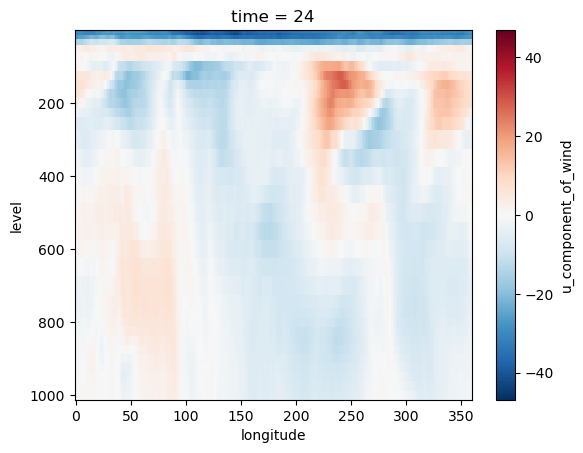

In [18]:
import matplotlib.pyplot as plt
data['u_component_of_wind'].sel(latitude=slice(-10, 10)).mean(dim='latitude').isel(time=1).plot(y='level')
plt.gca().invert_yaxis()
plt.show()

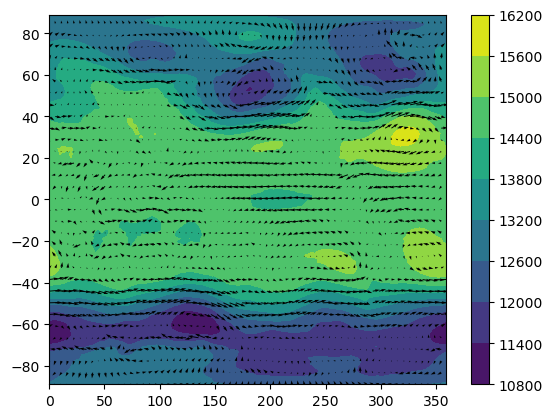

In [23]:
plt.figure()
plt.contourf(
    data['temperature'].longitude,
    data['temperature'].latitude,
    data['geopotential'].sel(level=850).mean(dim='time').T
)
plt.colorbar()

plt.quiver(
    data['temperature'].longitude[::4],
    data['temperature'].latitude[::4],
    data['u_component_of_wind'].sel(level=850).mean(dim='time').T[::4, ::4],
    data['v_component_of_wind'].sel(level=850).mean(dim='time').T[::4, ::4],
)

plt.show()

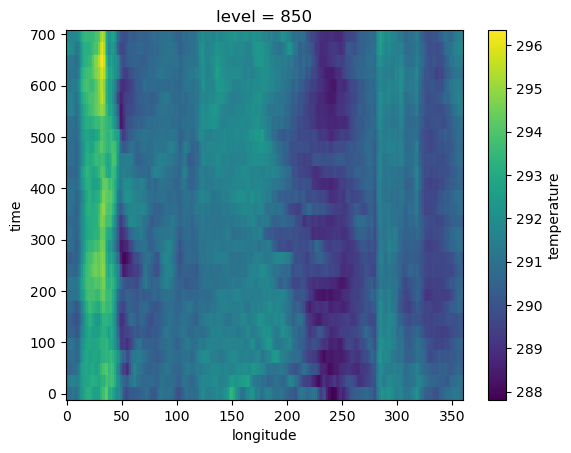

In [24]:
 data['temperature'].sel(latitude=slice(-5,5)).mean(dim='latitude').sel(level=850).plot(x='longitude')

In [26]:
 data['temperature'].sel(latitude=slice(-5,5)).mean(dim='latitude').sel(level=850).time

<xarray.DataArray 'time' (time: 30)> Size: 120B
array([  0,  24,  48,  72,  96, 120, 144, 168, 192, 216, 240, 264, 288, 312,
       336, 360, 384, 408, 432, 456, 480, 504, 528, 552, 576, 600, 624, 648,
       672, 696], dtype=int32)
Coordinates:
    level    int32 4B 850
  * time     (time) int32 120B 0 24 48 72 96 120 144 ... 576 600 624 648 672 696

In [1]:
import xarray as xr
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xr.open_zarr(
    era5_path, chunks=None, storage_options=dict(token='anon')
)

In [2]:
full_era5

<xarray.Dataset> Size: 4PB
Dimensions:                                                          (
                                                                      time: 1323648,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 11MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 5TB ...
Attributes:
    last_updated:           2025-06-30 01:47:00.511182+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-02-28
    valid_time_stop_era5t:  2025-06-24

In [46]:
demo_start_time = '2018-01-01'
demo_end_time = '2018-01-30'
data_inner_steps = 24
# sliced_era5 = full_era5.pipe(
#         xarray_utils.selective_temporal_shift,
#         variables=full_era5.specific_humidity,
#         time_shift='24 hours',
#     ).sel(time=slice(demo_start_time, demo_end_time, data_inner_steps)).compute()

import numpy as np
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 30 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)

sliced_era5 = full_era5.sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
sliced_era5['time'] = times

In [47]:
sliced_era5

<xarray.Dataset> Size: 83GB
Dimensions:                                                          (time: 30,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) int64 240B ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 125MB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 125MB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 125MB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 125MB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 125MB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 125MB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 125MB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 125MB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 125MB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 125MB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 125MB ...
    zero_degree_level                                                (time, latitude, longitude) float32 125MB ...
Attributes:
    last_updated:           2025-06-30 01:47:00.511182+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-02-28
    valid_time_stop_era5t:  2025-06-24

In [50]:
sliced_data = data.sel(level=850)
sliced_data['time'] = times

In [12]:
# data
eval_era5

<xarray.Dataset> Size: 658MB
Dimensions:                                                          (time: 30,
                                                                      longitude: 128,
                                                                      latitude: 64,
                                                                      level: 37)
Coordinates:
  * level                                                            (level) int64 296B ...
  * time                                                             (time) int64 240B ...
  * longitude                                                        (longitude) float64 1kB ...
  * latitude                                                         (latitude) float64 512B ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, longitude, latitude) float32 983kB ...
    100m_v_component_of_wind                                         (time, longitude, latitude) float32 983kB ...
    10m_u_component_of_neutral_wind                                  (time, longitude, latitude) float32 983kB ...
    10m_u_component_of_wind                                          (time, longitude, latitude) float32 983kB ...
    10m_v_component_of_neutral_wind                                  (time, longitude, latitude) float32 983kB ...
    10m_v_component_of_wind                                          (time, longitude, latitude) float32 983kB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, longitude, latitude) float32 983kB ...
    wave_spectral_directional_width_for_wind_waves                   (time, longitude, latitude) float32 983kB ...
    wave_spectral_kurtosis                                           (time, longitude, latitude) float32 983kB ...
    wave_spectral_peakedness                                         (time, longitude, latitude) float32 983kB ...
    wave_spectral_skewness                                           (time, longitude, latitude) float32 983kB ...
    zero_degree_level                                                (time, longitude, latitude) float32 983kB ...

In [81]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

AttributeError: 'Dataset' object has no attribute 'data_coords'

In [26]:
combined_ds = xr.concat([eval_era5.transpose('time','latitude','longitude','level'), data.transpose('time','latitude','longitude','level')], 'model')
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

In [31]:
combined_ds.longitude

<xarray.DataArray 'longitude' (longitude: 325)> Size: 3kB
array([  0.     ,   1.40625,   2.8125 , ..., 357.1875 , 357.1875 , 358.59375])
Coordinates:
  * longitude  (longitude) float64 3kB 0.0 1.406 2.812 ... 357.2 357.2 358.6

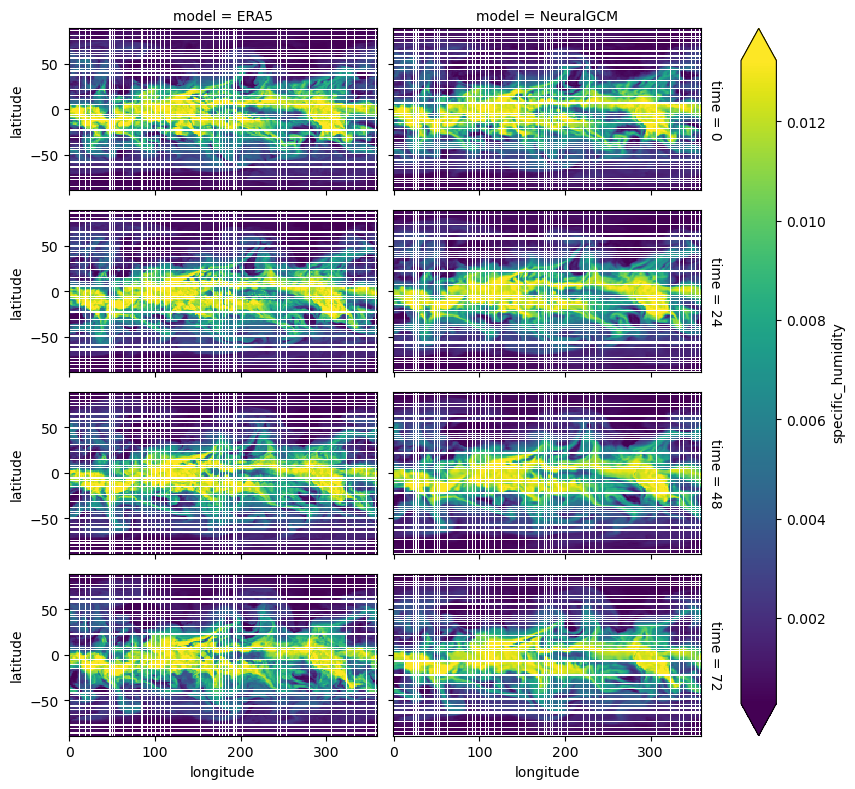

In [27]:
combined_ds.specific_humidity.isel(time=slice(0,4)).sel(level=850).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
);

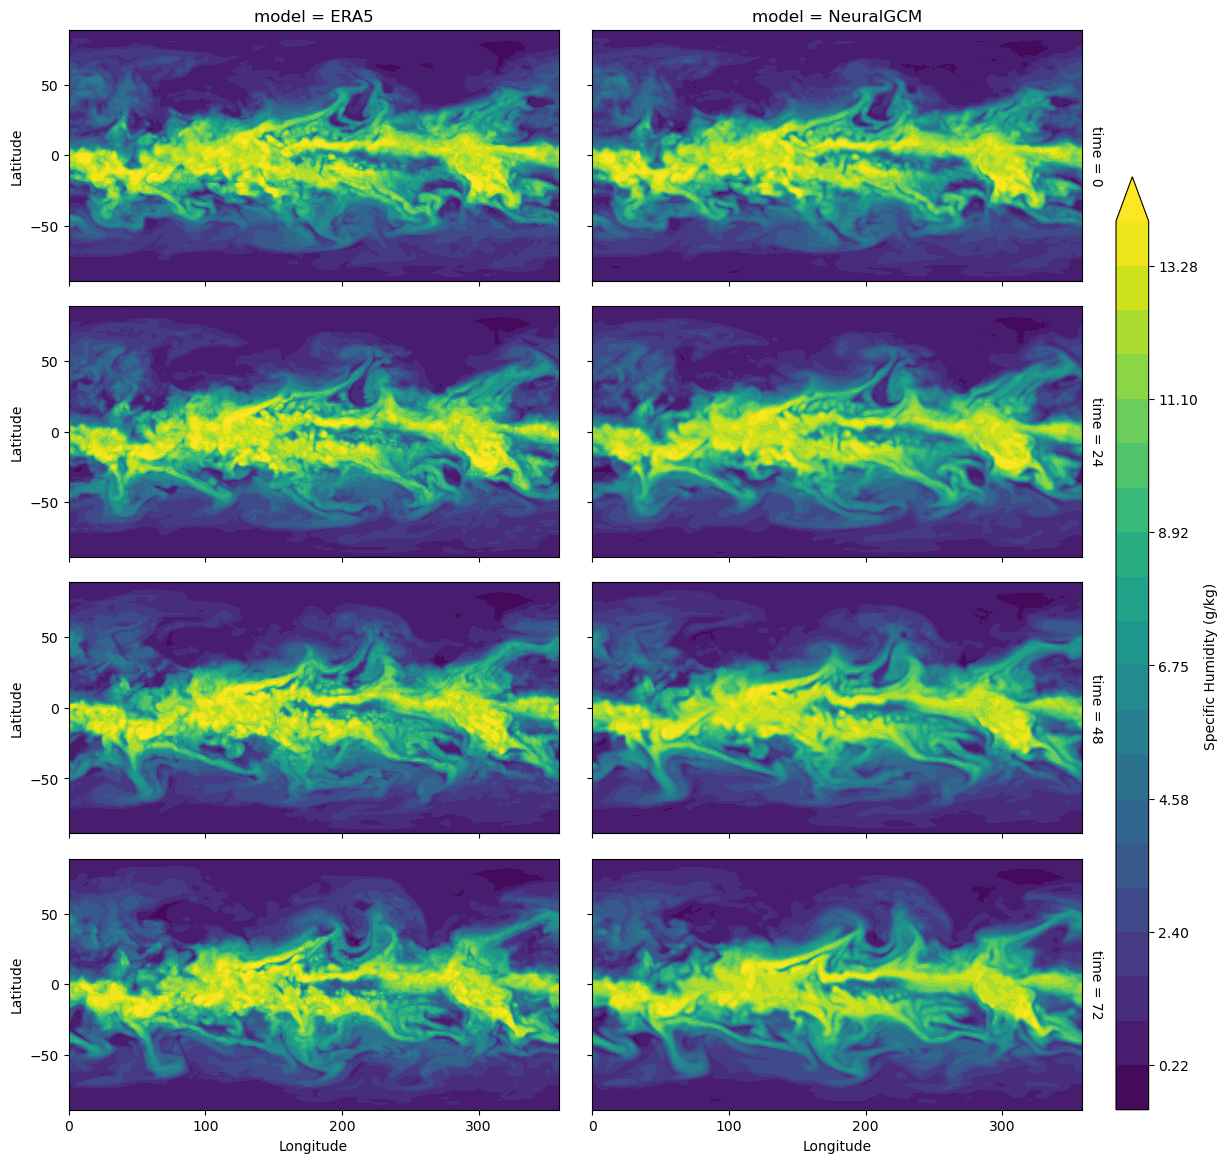

In [73]:
from matplotlib import colors as mcolors
from matplotlib import ticker as mticker
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(4, 3, figure=fig, width_ratios = [30, 30, 2])
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.1, wspace=0.1)

left_ax = []
left_ax.append(fig.add_subplot(gs[0, 0]))
left_ax.append(fig.add_subplot(gs[1, 0]))
left_ax.append(fig.add_subplot(gs[2, 0]))
left_ax.append(fig.add_subplot(gs[3, 0]))

right_ax = []
right_ax.append(fig.add_subplot(gs[0, 1]))
right_ax.append(fig.add_subplot(gs[1, 1]))
right_ax.append(fig.add_subplot(gs[2, 1]))
right_ax.append(fig.add_subplot(gs[3, 1]))

cbar_axis = fig.add_subplot(gs[:, -1])

levels = np.linspace(-0.5, 14, 21)


left_ax[0].set_title('model = ERA5')
right_ax[0].set_title('model = NeuralGCM')
for index, time in enumerate(range(0, 4, 1)):
    left_ax[index].contourf(
        eval_era5.longitude,
        eval_era5.latitude,
        1000*eval_era5.specific_humidity.sel(time=times[time]).sel(level=850).T,
        levels=levels,
        extend='max',
        cmap='viridis'
    )
    left_ax[index].set_ylabel('Latitude')
    left_ax[index].set_yticks([-50, 0, 50])
    left_ax[index].set_xticks([0, 100, 200, 300], labels=[])
    im = right_ax[index].contourf(
        data.longitude,
        data.latitude,
        1000*data.specific_humidity.sel(time=times[time]).sel(level=850).T,
        levels=levels,
        extend='max',
        cmap='viridis'
    )
    right_ax[index].yaxis.set_label_position("right")
    right_ax[index].set_yticks([-50, 0, 50], labels=[])
    right_ax[index].set_xticks([0, 100, 200, 300], labels=[])
    right_ax[index].set_ylabel(f"time = {times[time]}", rotation=270, labelpad=15)
    cbar = fig.colorbar(im, cax=cbar_axis)
    cbar.set_label('Specific Humidity (g/kg)')

left_ax[3].set_xlabel('Longitude')
right_ax[3].set_xlabel('Longitude')
left_ax[3].set_xticks([0, 100, 200, 300], labels=[0, 100, 200, 300])
right_ax[3].set_xticks([0, 100, 200, 300], labels=[0, 100, 200, 300])

plt.show()

In [80]:
# # print(data.dims)
# # print(eval_era5.dims)

# test = data.isel(time=0)
# test

model.inputs_from_xarray(eval_era5.isel(time=0))

# data

UFuncTypeError: ufunc 'subtract' cannot use operands with types dtype('int64') and dtype('<M8[h]')

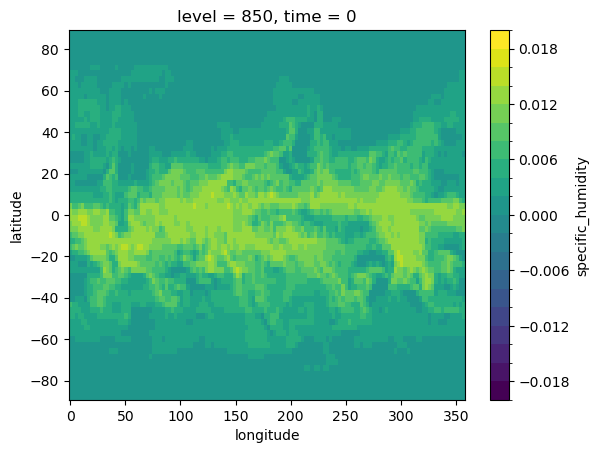

In [18]:
eval_era5.specific_humidity.isel(time=0).sel(level=850).plot(x='longitude', y='latitude', cmap='viridis', levels=np.linspace(-0.02, 0.02, 21))